<a href="https://colab.research.google.com/github/NicoZenith/Transformers/blob/main/BERT_Pretraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import zipfile
import io

from torch.utils.data import Dataset
from transformers import AutoTokenizer

from transformer_layers import * 
from utils import * 

model_name = "bert-base-uncased"  # Replace with the desired pre-trained model
tokenizer = AutoTokenizer.from_pretrained(model_name)



/Users/deperrois/PycharmProjects/Transformers/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import WikiText2 dataset

In [2]:

url = 'https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip'
response = requests.get(url)

with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
    zip_file.extractall()

train_file = 'wikitext-2/wiki.train.tokens'
valid_file = 'wikitext-2/wiki.valid.tokens'
test_file = 'wikitext-2/wiki.test.tokens'

with open(train_file, 'r', encoding='utf-8') as file:
    train_data = file.read()

with open(valid_file, 'r', encoding='utf-8') as file:
    valid_data = file.read()

with open(test_file, 'r', encoding='utf-8') as file:
    test_data = file.read()

Let's first create a function that takes one (or two) sentences as input, and add the required tokens cls and sep. We also output the `segment` variable, that tells whether it is the first or the 2nd sentence.  

In [3]:
def get_tokens_and_segments(tokens_a, tokens_b=None):
    """
    From one or two sentence, concatenate the BERT specific tokens and generate the segment encoding
    :tokens_a: tokens from the first sentence
    :tokens_b: tokens from the second sentence
    :return: the concatenated tokens sequence and the associated segments encoding (0 for 1st sentence, 1 for 2nd)
    """
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens = tokens + tokens_b + ['<sep>']
        segments = segments + [1] * (len(tokens_b) + 1)
    return tokens, segments



In [4]:
tokens_a = tokenizer.tokenize( "Hello I would like to talk about machine learning")
tokens_b = tokenizer.tokenize( "It is going to be very interesting")

tokens, segments = get_tokens_and_segments(tokens_a, tokens_b)
print(tokens)
print(segments)


['<cls>', 'hello', 'i', 'would', 'like', 'to', 'talk', 'about', 'machine', 'learning', '<sep>', 'it', 'is', 'going', 'to', 'be', 'very', 'interesting', '<sep>']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]


## BERT architecture 

We here define the `BERTEncoder` class that builds the architecture of the BERT encoder-only transformer. A particular choice is to use a trainable position embedding matrix, a bidirectional attention mechanism `forward_mask=None` and an adaptable attention mask for the padded tokens built from `valid_lens`.  

In [5]:
import torch.nn as nn
import torch
from torch.nn import functional as F
import math

device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_hiddens = 384
n_head = 8
n_layer = 4
dropout = 0.2
d_model = 384
max_len = 64
vocab_size = 30526



class BERTEncoder(nn.Module):
    """ BERT Encoder """
    def __init__(self, d_model, num_heads):
        super(BERTEncoder, self).__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, d_model)
        self.segment_embedding = nn.Embedding(2, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len,
                                                      d_model))
        self.blocks = nn.Sequential(*[Block( d_model, num_heads, dropout) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(d_model) # final layer norm
        self.lm_head = nn.Linear(d_model, vocab_size)

        self.apply(self._init_weights)


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, tokens, segments, valid_lens=None, forward_mask=None):

        X = self.token_embedding_table(tokens) + self.segment_embedding(segments)

        X = X + self.pos_embedding[:, :X.shape[1], :]
        for blk in self.blocks:
            X = blk(X, valid_lens, forward_mask=None) # (B,T,C)
        X = self.ln_f(X) # (B,T,C)

        return X


In [6]:
d_model, num_heads = 384, 4

encoder = BERTEncoder(d_model, num_heads)
batch_size = 2
tokens = torch.randint(low=0, high=vocab_size, size = (batch_size, max_len), dtype=torch.int)
segments = torch.zeros((batch_size, max_len), dtype=torch.int)

X = encoder(tokens, segments)
print(X.shape)

torch.Size([2, 64, 384])


## Masked language modeling

BERT randomly masks tokens and uses from the bidirectional context to predict the mask token in a self-supervision fashion. This is the masked language mode.

The idea is to select 15% of the tokens at random and try to predict them in the output layer of the BERT Encoder. To avoid the trivial solution of picking the input as an output, we rarely provide the actual token as input. More precisely, it will be replaced by:
- a special `<mask>` token 80% of the time
- another token picked randomly from the vocabulary 10% of the time
- the same token 10% of the time (not replaced)

We implement the following `MaskLM` class to predict the tokens of the selected masked tokens. This is perform by a 1 hidden layer MLP, that takes as input the predicted tokens. To perform the forward pass, we thus provide the positions of each masked token for each data point from the minibatch, along with the output of the encoder X.

In [77]:
class MaskLM(nn.Module):
    def __init__(self, d_model):
        super(MaskLM, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.LayerNorm(d_model),
            nn.Linear(d_model, vocab_size)
        )

    def forward(self, X, pred_positions):
        num_predictions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        batch_idx = torch.repeat_interleave(batch_idx, num_predictions)
        masked_X = X[batch_idx, pred_positions]
        masked_X = masked_X.reshape((batch_size, num_predictions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat


In [78]:
mask = MaskLM(d_model)
pred_positions = torch.tensor([[0, 5, 9], [3, 5, 9]])
mlm_Y_hat = mask(X, pred_positions)


In [79]:
print(mlm_Y_hat.shape)

torch.Size([2, 3, 30526])


Having the ground truth labels `mlm_Y` of the predicted probabilites for each masked token `mlm_Y_hat`, we can compute the cross-entropy-loss between these.

In [80]:
mlm_Y = torch.tensor([[0, 5, 9], [3, 5, 9]])
loss = nn.CrossEntropyLoss(reduction='none')
mlm_loss = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1))
mlm_loss.shape

torch.Size([6])

## Next sentence prediction

To help understand the relationship between two text sequences, BERT considers a binary classification task, *Next Sentence Prediction*, in its pretraining. The sentence pairs are half of the time following each other (label True), half of the time taken as random (label False).

We construct a `NextSentencePred()` class that uses a one-hidden-layer MLP to predict whether the second sentence is following the first sentence or not. The BERT representation of the special token `<cls>` contains information from both classes (due to the self-attention mechanism), and the prediction is made from this predicted token.


In [82]:
class NextSentencePred(nn.Module):
    def __init__(self, d_model):
        super(NextSentencePred, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, 2)
        )

    def forward(self, X):
        cls_X = X[:, 0, :]
        return self.mlp(cls_X)


In [83]:
nsp = NextSentencePred(d_model)
prediction = nsp(X)
prediction.shape

torch.Size([2, 2])

## Putting it altogether

In [86]:
class BERTModel(nn.Module):
    def __init__(self, d_model, num_heads):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(d_model, num_heads)
        self.mlm = MaskLM(d_model)
        self.nsp = NextSentencePred(d_model)


    def forward(self, tokens, segments, pred_positions=None, valid_lens=None):
        encoded_X = self.encoder(tokens, segments)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None

        nsp_Y_hat = self.nsp(encoded_X)

        return encoded_X, mlm_Y_hat, nsp_Y_hat



## A closer look on the dataset 

In [87]:
print(train_data[:1000])

 
 = Valkyria Chronicles III = 
 
 Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . <unk> the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . 
 The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more <unk> for series newcomers . Char

We use the function `_read_wiki` to obtain lists of lists of lists.

In [88]:
paragraphs = _read_wiki('wikitext-2')

In [89]:
paragraphs[35]

['the music video for " loverboy " received generally mixed reviews from critics , many of whom felt carey was portrayed in an overtly sexual manner',
 'a writer from the guardian criticized the video , calling it " <unk> " and describing carey \'s choreography as " running <unk> "',
 'slant magazine \'s sal cinquemani felt the video was " brilliantly over @-@ the @-@ top " , while an anonymous columnist from nme commented that it would cause male viewers to " play with themselves " after watching',
 'in a countdown of the " the 5 least <unk> music videos " , <unk> <unk> from nme included the video at number three , writing how the singer " spins with the mad @-@ eyed grace of someone who hasn ’ t been to sleep for 72 hours " ( referring to carey \'s mention of insomnia as a reason for her breakdown )',
 "<unk> burns of the michigan daily was critical of carey 's portrayal in the video , primarily her double @-@ handkerchief bra",
 'he felt that in doing so , carey was <unk> herself an

In the following we implement helper functions for the two BERT pretraining tasks: next sentence prediction and masked language modeling.

#### NSP

In [90]:
def _get_next_sentence(sentence, next_sentence, paragraphs):
    """
    Generate a pair of sentences along with a label assessing whether the 2 sentences are following each other

    :sentence: sentence picked among all paragraphs
    :next_sentence: sentence following the first sentence
    :paragraphs: list of lists of lists, all corpus data
    :return: pair of sentence and the label True or False

    """
    if random.random()< 0.5:
        is_next = True
    else:
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False

    return sentence, next_sentence, is_next


In [91]:
def _get_nsp_data_from_paragraph(paragraph, paragraphs, max_len):
    """
    Generate training examples for NSP by invoking the _get_next_sentence function
    :paragraph: list of sentences, where each sentence is a list of tokens
    :paragraphs: list of paragraphs
    :max_len: maximum length of a BERT input sequence
    :return: list of tuples (tokens, segments, is_next)
    """
    nsp_data_from_paragraph = []
    for i in range(len(paragraph)-1):
        sentence = paragraph[i]
        next_sentence = paragraph[i+1]

        tokens_a, tokens_b, is_next =  _get_next_sentence(sentence, next_sentence, paragraphs)

        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            continue

        tokens, segments = get_tokens_and_segments(tokens_a, tokens_b)
        nsp_data_from_paragraph.append((tokens, segments, is_next))
    return nsp_data_from_paragraph



In [92]:
paragraphs = [[tokenizer.tokenize(sentence) for sentence in paragraph] for paragraph in paragraphs]

In [93]:
nsp_data_from_paragraph = _get_nsp_data_from_paragraph(paragraphs[0], paragraphs, max_len=512)

In [94]:
print(nsp_data_from_paragraph[0])

(['<cls>', 'the', 'university', 'is', 'the', 'home', 'of', 'two', 'centers', 'of', 'excellence', ':', 'the', 'center', 'of', 'excellence', 'in', '<', 'un', '##k', '>', 'and', 'marine', '<', 'un', '##k', '>', 'and', 'the', 'center', 'for', 'ocean', 'energy', 'technology', '<sep>', 'these', 'centers', 'have', 'been', 'selected', 'by', 'florida', "'", 's', '<', 'un', '##k', '>', 'technology', 'commission', 'to', 'receive', 'grants', 'to', 'continue', 'and', 'increase', 'their', 'operations', '<sep>'], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], True)


#### MLM

In [95]:
def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds, vocab):
    """
    Generate training examples for the masked language modeling task from a BERT input sequence.
    At each prediction position, the token may be replaced by a special '<mask>' token or a random token, or remain unchanged.

    :tokens: list of otkens representing a BERT input sequence
    :candidate_pred_positions: list of token indices of the BERT input sequence excluding those of special tokens
    :num_mlm_preds: number of predictions
    :return: input tokens after possible replacement, token indices where predictions take place and labels for these predictions
    """
    indices = torch.randperm(len(candidate_pred_positions))[:num_mlm_preds]
    pred_positions_and_labels = []
    for i in range(num_mlm_preds):
        token_to_predict = tokens[indices[i]]
        random_num = random.random()
        if random_num < 0.8:
            tokens[indices[i]] = '<mask>'
        elif random_num > 0.9:
            tokens[indices[i]] = random.choice(list(vocab.keys()))
        pred_positions_and_labels.append((indices[i], token_to_predict))
    return tokens, pred_positions_and_labels

In [96]:
tokens = paragraphs[0][0]
candidate_pred_positions = paragraphs[0][0]
vocab = tokenizer.vocab
num_mlm_preds = 3

tokens, pred_positions_and_labels = _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds, vocab)
print(tokens)
print(pred_positions_and_labels)


['the', 'university', 'is', 'the', 'home', 'of', 'two', 'centers', 'of', 'excellence', '<mask>', 'the', 'center', 'of', 'excellence', 'in', '<', 'un', '##k', '>', 'and', 'marine', '<', 'un', '##k', '>', 'and', 'the', 'center', 'grunted', 'ocean', 'energy', 'technology']
[(tensor(10), ':'), (tensor(29), 'for'), (tensor(4), 'home')]


In [97]:
def _get_mlm_data_from_tokens(tokens, vocab):
    """
    Returns indices of the input tokens (after possible token replacement) by invoking the _replace_mlm_tokens function,
    along with the token indices where predictions take place, and label indices for these predictions
    :tokens: list of strings
    :vocab: list of vocabulary words
    """
    candidate_pred_positions = []
    for i, token in enumerate(tokens):
        # Special tokens are not predicted in the masked language modeling task
        if token in ['<cls>', '<sep>']:
            continue
        candidate_pred_positions.append(i)
    # 15% of the random tokens are predicted in the masked language modeling task
    num_mlm_preds = max(1, round(len(tokens)*0.15))
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds, vocab)
    pred_positions_and_labels = sorted(pred_positions_and_labels, key=lambda x:x[0])
    pred_positions = [v[0] for v in pred_positions_and_labels]
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels]

    mlm_input_tokens_ids = tokenizer.convert_tokens_to_ids(mlm_input_tokens)
    mlm_pred_labels_ids = tokenizer.convert_tokens_to_ids(mlm_pred_labels)

    return mlm_input_tokens_ids, pred_positions, mlm_pred_labels_ids


In [98]:
special_tokens = ['<pad>', '<mask>', '<cls>', '<sep>']

ids = tokenizer.convert_tokens_to_ids(special_tokens)


tokenizer.add_tokens(special_tokens)

mlm_input_tokens_ids, pred_positions, mlm_pred_labels_ids = _get_mlm_data_from_tokens(tokens, vocab)

In [99]:
print(mlm_input_tokens_ids)
print(pred_positions)
print(mlm_pred_labels_ids)

[1996, 2118, 2003, 1996, 30523, 1997, 2048, 15976, 1997, 30523, 30523, 1996, 30523, 1997, 8012, 1999, 1026, 4895, 2243, 1028, 1998, 3884, 1026, 4895, 2243, 1028, 1998, 1996, 2415, 30523, 4153, 2943, 2974]
[tensor(4), tensor(7), tensor(9), tensor(12), tensor(29)]
[2188, 6401, 8012, 2415, 14922]


#### Transforming text into the pretraining dataset

In [100]:
def _pad_bert_inputs(examples, max_len, vocab):
    """
    Append the special '<pad>' token to the inputs
    :examples: contain the outputs from the helper functions _get_nsp_data_from_paragraph and _get_mlm_data_from_tokens
    :max_len: maximum number of tokens in a BERT input sequence
    :vocab: list of vacab words
    """
    max_num_mlm_preds = round(max_len * 0.15)
    all_token_ids, all_segments, valid_lens = [], [], []
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []

    for (token_ids, pred_positions, mlm_pred_label_ids, segments, is_next) in examples:
        all_token_ids.append( torch.tensor(token_ids + [vocab['<pad>']] * (max_len - len(token_ids)), dtype=torch.long ))
        all_segments.append( torch.tensor(segments + [0] * (max_len - len(segments)), dtype=torch.long) )
        # 'valid_lens' excludes count of '<pad>' tokens
        valid_lens.append(torch.tensor(len(token_ids), dtype=torch.int))
        all_pred_positions.append(torch.tensor(pred_positions + [0] * (max_num_mlm_preds - len(pred_positions)), dtype=torch.long ))
        # predictions of padded tokens will be filtered out in the loss via multiplication of 0 weights
        all_mlm_weights.append(
            torch.tensor([1.0] * len(mlm_pred_label_ids) + [0.0] * (max_num_mlm_preds - len(pred_positions)), dtype=torch.float32))
        all_mlm_labels.append(
            torch.tensor(mlm_pred_label_ids + [0]*(max_num_mlm_preds - len(mlm_pred_label_ids)) , dtype=torch.long))
        nsp_labels.append(torch.tensor(is_next, dtype=torch.long))


    return (all_token_ids, all_segments, valid_lens, all_pred_positions, all_mlm_weights, all_mlm_labels, nsp_labels)



We can now construct the `_WikiTextDataset` class for pretraining BERT. By implementing the `__getitem__` method, we can arbitrarily access the pretraining (MLM and NSP) examples generated from a pair of setences from the WikiText2 corpus.
We use the WordPiece tokenizer (vocab_size = 30000).

In [101]:


class _WikiTextDataset(Dataset):
    def __init__(self, tokenizer, paragraphs, max_len):
        """
        :paragraphs: contains a list of paragraphs, paragraphs[i] is a list of sentence strings
        We want to output paragraphs where paragraphs[i] is a list of sentences
        """
        tokenizer.add_tokens(['<pad>', '<mask>', '<cls>', '<sep>'])
        self.vocab = tokenizer.vocab

        # Get data for NSP task
        examples = []
        for paragraph in paragraphs:
            examples.extend( _get_nsp_data_from_paragraph(paragraph, paragraphs, max_len) )


        # Get data for MLM task
        examples = [ (_get_mlm_data_from_tokens(tokens, self.vocab) + (segments, is_next)) for tokens, segments, is_next in examples ]


        # Pad inputs
        (self.all_token_ids, self.all_segments, self.valid_lens, self.all_pred_positions, self.all_mlm_weights, self.all_mlm_labels, self.nsp_labels ) = _pad_bert_inputs(examples, max_len, self.vocab)

        # print(len(self.all_token_ids))


    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx], self.valid_lens[idx],
         self.all_pred_positions[idx], self.all_mlm_weights[idx], self.all_mlm_labels[idx], self.nsp_labels[idx])

    def __len__(self):
        return len(self.all_token_ids)



In [102]:
from torch.utils.data import DataLoader

batch_size = 32
max_len = 64


train_dataset = _WikiTextDataset(tokenizer, paragraphs, max_len)


In [103]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [104]:
batch = next(iter(train_dataloader))
tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y = batch

In [105]:
print(tokens_X.shape, segments_X.shape, valid_lens_x.shape, pred_positions_X.shape, mlm_weights_X.shape, mlm_Y.shape, nsp_y.shape)

torch.Size([32, 64]) torch.Size([32, 64]) torch.Size([32]) torch.Size([32, 10]) torch.Size([32, 10]) torch.Size([32, 10]) torch.Size([32])


In [106]:
print(valid_lens_x)

tensor([41, 37, 29, 58, 49, 60, 26, 46, 22, 41, 57, 49, 55, 56, 51, 48, 62, 49,
        28, 60, 61, 30, 60, 62, 37, 38, 59, 45, 64, 51, 59, 56],
       dtype=torch.int32)


## Pretraining BERT

In [107]:
net = BERTModel(d_model, num_heads)
loss = nn.CrossEntropyLoss()

def _get_batch_loss_bert(net, loss, vocab_size, tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y):
    # Forward pass
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X, pred_positions_X, valid_lens_x)

    # Compute MLM loss
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) * mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # Compute NSP loss
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l



In [108]:
net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

num_epochs = 5



nsp_losses = []
mlm_losses = []

for epoch_i in range(num_epochs):
    for i, batch in enumerate(train_dataloader):

        optimizer.zero_grad()


        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y = batch
        mlm_l, nsp_l, l = _get_batch_loss_bert(net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                             pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
        l.backward()
        optimizer.step()
        nsp_losses.append(nsp_l.item())
        mlm_losses.append(mlm_l.item())

        if i%50 == 0:
            print(l.item())



11.215914726257324


KeyboardInterrupt: 

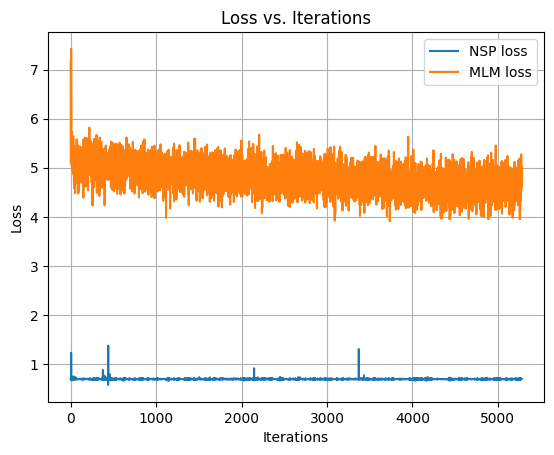

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a list named "losses" with the loss values
iterations = range(len(nsp_losses))

plt.plot(iterations, nsp_losses, label="NSP loss")
plt.plot(iterations, mlm_losses, label="MLM loss")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations')
plt.grid(True)
plt.legend()
plt.show()